In [8]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from climpred import HindcastEnsemble
import climpred

In [9]:
# Decode times for 360 day calendars
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [10]:
# Select skill score
score='acc'

In [11]:
#Read Obs File
obsurl='/shared/ccsm4/kpegion/obs2/RMM/rmmint1979-Present.txt'
cols=['year','month','day','rmm1','rmm2','phase','amp','datasource']
obspd=pd.read_table(obsurl,skiprows=2,delim_whitespace=True,header=None,names=cols)
obspd['time']=pd.to_datetime(obspd[['year','month','day']])
obspd=obspd.drop(columns=['year','month','day','datasource','phase','amp'])
print(obspd)

           rmm1      rmm2       time
0      1.867320  1.162380 1974-06-03
1      1.868380  1.122380 1974-06-04
2      1.923860  1.404810 1974-06-05
3      1.574160  1.744920 1974-06-06
4      0.977483  1.856400 1974-06-07
...         ...       ...        ...
15608  0.665826 -1.181078 2017-07-20
15609  0.778615 -0.953263 2017-07-21
15610  0.891819 -0.704285 2017-07-22
15611  0.902347 -0.338409 2017-07-23
15612  1.027518 -0.029707 2017-07-24

[15613 rows x 3 columns]


In [12]:
groups=['GMAO'] #,'RSMAS','ESRL','ECCC','NRL','EMC']           
models=['GEOS_V2p1'] #,'CCSM4','FIMr1p1','GEM','NESM','GEFS']  
varnames=['RMM1'] #,'RMM2']

RMM1
GEOS_V2p1
<xarray.Dataset>
Dimensions:  (lead: 6)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6
Data variables:
    rmm1     (lead) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     510
    number_of_members:             4
    metric:                        pearson_r
    comparison:                    e2r
    units:                         None
    created:                       2019-11-15 17:23:19


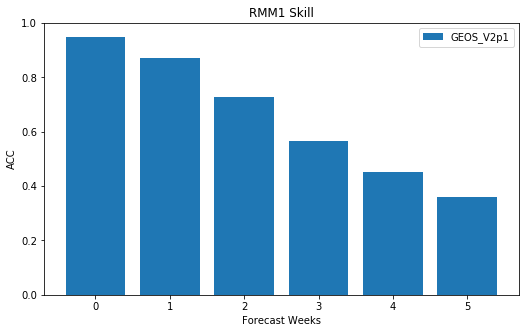

In [13]:
# Create the figure
plt.figure(figsize=(8.5,11))

# Loop over all variables
for i,varname in enumerate(varnames, start=1):
    
    print(varname)
    
    # Set the subplot
    plt.subplot(2,1,i)
    
    # Read the obs data, only keeping the desired variable
    obspd2=obspd[['time',varname.lower()]].set_index('time').to_xarray() 
    
    # Handle missing
    obspd2 = obspd2.where(obspd2[varname.lower()] <= 1e10)  
    
    # Make weekly averages 
    obspd3=obspd2.rolling(time=7,center=False).mean().dropna(dim='time')

        
    # Loop over all groups and models
    for group,model in zip(groups,models):

        print(model)
        
        # Read data from IRI Server
        url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.'+group+'/.'+model+'/.hindcast/.RMM/.'+varname+'/dods/'
        fullda = xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 45}).dropna(dim='S',how='all')
        
        # Make the lead an integer
        fullda['L']=(fullda['L']-0.5).astype('int')
        
        # Convert times to datetime64
        fullda = decode_cf(fullda, 'S')
        fullda['S']=pd.to_datetime(fullda.S.values.astype(str))
        fullda['S']=pd.to_datetime(fullda['S'].dt.strftime('%Y%m%d 00:00'))
        
        # Change dimension names to those needed by climpred
        fcst=fullda.rename({'S': 'init','L': 'lead','M': 'member', varname : varname.lower()})
        
        # Make weekly averages
        fcst2=fcst.rolling(lead=7,center=False).mean().dropna(dim='lead')
        
        # Create new xarray DataArray with weekly data
        nleads=fcst2['lead'][::7].size
        fcst3=xr.DataArray(fcst2[varname.lower()][:,:,::7], 
                           coords={'init' : fcst2['init'],
                                   'member': fcst2['member'],
                                   'lead': np.arange(1,nleads+1), 
                                   },
                           dims=['init', 'member','lead'])
        fcst3.name = varname.lower()
        
        # Set lead units to weeks as required by climpred
        fcst3['lead'].attrs={'units': 'weeks'}
        
        # Create the Hindcast Ensemble object and add observations as the reference/verification
        hindcast = HindcastEnsemble(fcst3)
        hindcast=hindcast.add_reference(obspd3, 'observations')
        
        # Calculate the skill for this model
        skill = hindcast.compute_metric(metric=score)
        print(skill)
        
        #Plot skill for this model
        x=np.arange(fcst3['lead'].size)
        plt.bar(x,skill[varname.lower()])
    
    #Add plotting labels
    plt.legend(models)
    plt.title(varname+' Skill')
    plt.xlabel('Forecast Weeks')
    plt.ylabel('ACC')
    plt.ylim(0.0, 1.0)

In [14]:
skill[varname.lower()].values

array([0.94796002, 0.87192991, 0.72647795, 0.56582234, 0.45044374,
       0.36065706])